In [11]:
import torch
device = torch.device("mps")

import evaluate
import sacrebleu
from tqdm import tqdm
import matplotlib.pyplot as plt

from datasets import Dataset
from peft import LoraConfig, get_peft_model, PeftModel
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments

In [12]:
# function to prepare the training and any other dataset
def prepare_data(eng_file_path, mai_file_path, data_type):
    # load the english and maithili texts files
    with open(eng_file_path, "r", encoding="utf-8") as en_file:
        eng_texts = en_file.readlines()

    with open(mai_file_path, "r", encoding="utf-8") as maithili_file:
        mai_texts = maithili_file.readlines()

    assert len(eng_texts) == len(mai_texts), "The number of sentences in both files must be the same."

    # clean the text files
    eng_texts_cleaned = [text.strip() for text in eng_texts]
    mai_texts_cleaned = [text.strip() for text in mai_texts]

    # create the dataset
    data = {
        "source_text": eng_texts_cleaned,
        "target_text": mai_texts_cleaned, 
    }
    dataset = Dataset.from_dict(data)

    # split the dataset into train, validation and test sets
    if data_type == "train":
        train_dataset, temp_dataset = dataset.train_test_split(test_size=0.1).values()
        val_dataset, test_dataset = temp_dataset.train_test_split(test_size=0.5).values()

        print(f"Training set size: {len(train_dataset)}")
        print(f"Validation set size: {len(val_dataset)}")
        print(f"Test set size: {len(test_dataset)}")

        return train_dataset, val_dataset, test_dataset
    elif data_type == "test":
        return dataset

# preprocessor function for tokenizer
def preprocess_function(examples, tokenizer):
    inputs = tokenizer(examples["source_text"], truncation=True, padding="max_length", max_length=128)
    targets = tokenizer(examples["target_text"], truncation=True, padding="max_length", max_length=128)
    inputs["labels"] = targets["input_ids"]
    return inputs

# function to tokenize the data
def tokenize_dataset(dataset, tokenizer):
    dataset_tokenized = dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    return dataset_tokenized

# function to move the dataset to device
def move_to_device(batch):
    # move each tensor in the batch to the MPS device
    for key in batch:
        batch[key] = torch.tensor(batch[key]).to(device)
    return batch

def save_dataset(dataset, file_path):
    with open(file_path, "w", encoding="utf-8") as f:
        for line in dataset: 
            f.write(line + "\n")

def average_words(dataset, source):
    total_words = sum(len(sentence.split()) for sentence in dataset[source])
    average = total_words / len(dataset)
    return average


In [13]:
train_dataset = prepare_data("./dataset/train/bpcc/train.eng_Latn", "./dataset/train/bpcc/train.mai_Deva", "test")

print(f"Average number of words per sentence: {average_words(train_dataset, 'source_text')}")
print(f"Average number of words per sentence: {average_words(train_dataset, 'target_text')}")

Average number of words per sentence: 16.055898785066066
Average number of words per sentence: 15.72975849123533


In [14]:
for i in range(2):
    print("Enlgish Text (source): ", train_dataset['source_text'][i])
    print("Maithili Text (target): ", train_dataset['target_text'][i])
    print("\n")


Enlgish Text (source):  India became the world's largest milk producer by 1998, surpassing the United States of America, with about 17 percent of global output in 2010–2011.
Maithili Text (target):  भारत वर्ष १९९८ धरि विश्वक सभसँ पैघ दुग्ध उत्पादक देश बनि गेल आ २०१०-११ मे वैश्विक उत्पादनक लगभग १७ प्रतिशतक सङ्ग संयुक्त राज्य अमेरिकाकेँ पछुआ देलक।


Enlgish Text (source):  From the Mumbai circuit comprising the Gujarat-Saurashtra belts alone it collected ₹18 crore (US$2.4 million).
Maithili Text (target):  मात्र गुजरात-सौराष्ट्र पट्टीवला मुम्बइ सर्किटसँ ई 18 करोड़ टाका (24 लाख अमेरिकी डालर) जुटौलक।




In [6]:
in22_mai_test = prepare_data("./dataset/test/IN22_test/gen/test.eng_Latn", "./dataset//test/IN22_test/gen/test.mai_Deva", "test")

print(f"Average number of words per sentence: {average_words(in22_mai_test, 'source_text')}")
print(f"Average number of words per sentence: {average_words(in22_mai_test, 'target_text')}")

Average number of words per sentence: 24.7529296875
Average number of words per sentence: 24.1787109375


In [15]:
for i in range(2):
    print("Enlgish Text (source): ", in22_mai_test['source_text'][i])
    print("Maithili Text (target): ", in22_mai_test['target_text'][i])
    print("\n")

Enlgish Text (source):  An appearance is a bunch of attributes related to the service person, like their shoes, clothes, tie, jewellery, hairstyle, make-up, watch, cosmetics, perfume, etc.
Maithili Text (target):  रूप सर्विसवला व्यक्तिसँ सम्बन्धित बहुत रास लक्षणक समूह होयत छै जेना हुनक जूता, कपड़ा, टाई, गहना, केश, श्रृंगार, घड़ी, प्रसाधन सामग्री, सेंट इत्यादि।


Enlgish Text (source):  Ajanta, located in the Aurangabad District of Maharashtra has twenty-nine caitya and vihara caves decorated with sculptures and paintings from the first century B.C.E. to the fifth century C.E.
Maithili Text (target):  महाराष्ट्रके औरंगाबादमे स्थित अजन्तामे पहिल शताब्दी ईसा पूर्व सँ पाँचम शताब्दी धरिक मूर्तिकला आ चित्रकला सँ सजाओल उन्नतीस टा चैत्य आ विहार अछि।




### Epoch 1


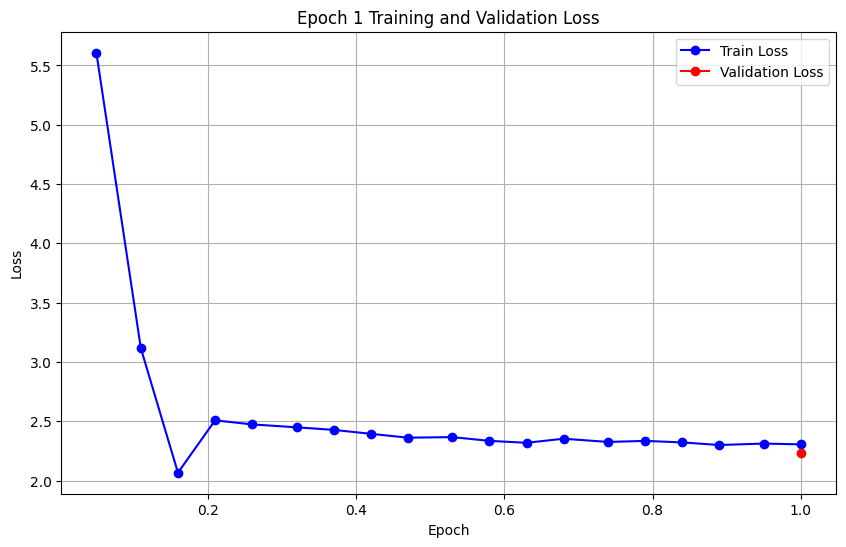

In [40]:
epoch = [0.05, 0.11, 0.16, 0.21, 0.26, 0.32, 0.37, 0.42, 0.47, 0.53, 0.58, 0.63, 0.68, 0.74, 0.79, 0.84, 0.89, 0.95, 1.0]
train_loss = [5.6068, 3.115, 2.067, 2.5084, 2.4742, 2.4497, 2.4281, 2.3949, 2.3623, 2.3671, 2.3354, 2.3193, 2.3536, 2.3264,
            2.3352, 2.3224, 2.3004, 2.3129, 2.3058]

plt.figure(figsize=(10, 6))
plt.plot(epoch[:len(train_loss)], train_loss, marker='o', linestyle='-', color='b')
plt.plot(epoch[-1], 2.23, marker='o', linestyle='-', color='r')  

plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch 1 Training and Validation Loss')
plt.grid(True)
plt.savefig('./img/epoch1/epoch1_train_loss.png')
plt.show()


### Epoch 2

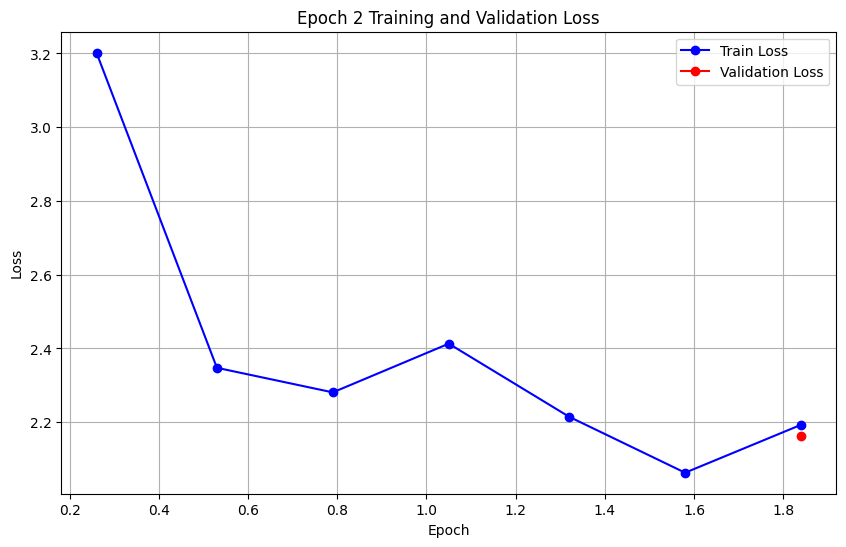

In [41]:
epoch = [0.26, 0.53, 0.79, 1.05, 1.32, 1.58, 1.84]
train_loss = [3.2021, 2.3476, 2.2809, 2.413, 2.2147, 2.063, 2.193 ]

plt.figure(figsize=(10, 6))
plt.plot(epoch[:len(train_loss)], train_loss, marker='o', linestyle='-', color='b')
plt.plot(epoch[-1], 2.1613, marker='o', linestyle='-', color='r')  

plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch 2 Training and Validation Loss')
plt.grid(True)
plt.savefig('./img/epoch2/epoch2_train_loss.png')
plt.show()

### Epoch 5

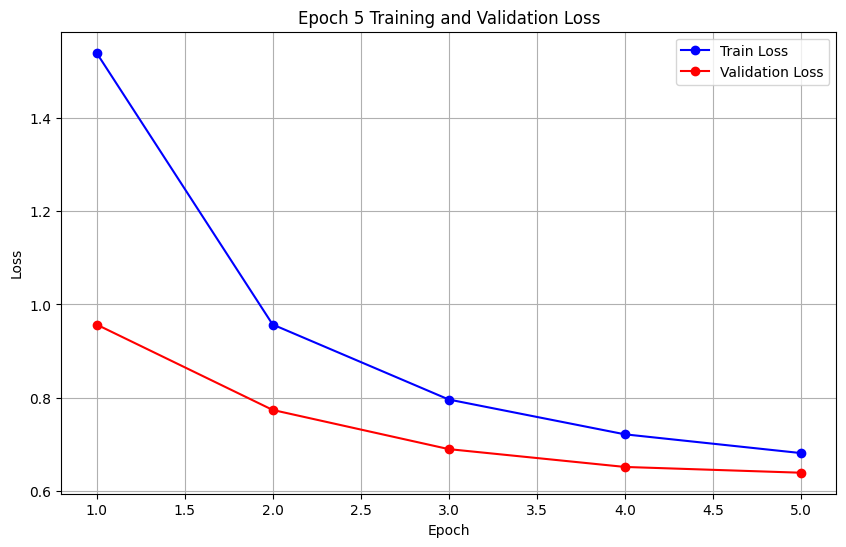

In [45]:
epoch = [1, 2, 3, 4, 5]
train_loss = [1.5394, 0.9569, 0.7961, 0.7215, 0.6813]
val_loss = [0.9569, 0.7738, 0.6898, 0.6516, 0.639220]

plt.figure(figsize=(10, 6))

plt.plot(epoch[:len(train_loss)], train_loss, marker='o', linestyle='-', color='b')
plt.plot(epoch[:len(val_loss)], val_loss, marker='o', linestyle='-', color='r')

plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch 5 Training and Validation Loss')
plt.grid(True)
plt.savefig('./img/epoch5/epoch5_train_loss.png')
plt.show()

In [ ]:
# load the model and tokenizer
model_path  = "Helsinki-NLP/opus-mt-en-hi"
finetuned_tokenizer = AutoTokenizer.from_pretrained(model_path) 
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
print("Parameter size: ", finetuned_model.num_parameters())


# Load the PEFT model
peft_model = PeftModel.from_pretrained(finetuned_model, model_path)
# Merge the LoRA weights into the model
peft_model.merge_and_unload()

# After merging, you can now use the merged model
print("Parameter size after merging:", peft_model.num_parameters())


Parameter size: 77265920
Parameter size after merging: 76381184


In [37]:
for name, param in finetuned_model.named_parameters():
    print(name)


model.shared.weight
model.encoder.embed_positions.weight
model.encoder.layers.0.self_attn.k_proj.weight
model.encoder.layers.0.self_attn.k_proj.bias
model.encoder.layers.0.self_attn.v_proj.weight
model.encoder.layers.0.self_attn.v_proj.bias
model.encoder.layers.0.self_attn.q_proj.weight
model.encoder.layers.0.self_attn.q_proj.bias
model.encoder.layers.0.self_attn.out_proj.weight
model.encoder.layers.0.self_attn.out_proj.bias
model.encoder.layers.0.self_attn_layer_norm.weight
model.encoder.layers.0.self_attn_layer_norm.bias
model.encoder.layers.0.fc1.weight
model.encoder.layers.0.fc1.bias
model.encoder.layers.0.fc2.weight
model.encoder.layers.0.fc2.bias
model.encoder.layers.0.final_layer_norm.weight
model.encoder.layers.0.final_layer_norm.bias
model.encoder.layers.1.self_attn.k_proj.weight
model.encoder.layers.1.self_attn.k_proj.bias
model.encoder.layers.1.self_attn.v_proj.weight
model.encoder.layers.1.self_attn.v_proj.bias
model.encoder.layers.1.self_attn.q_proj.weight
model.encoder.la

The model is not a PEFT LoRA model.


In [19]:
from peft import PeftModel

# Check if the model is a PEFT LoRA model
if isinstance(finetuned_model, PeftModel):
    print("The model is a PEFT LoRA model.")
    print(f"LoRA config: {finetuned_model.config}")
else:
    print("The model is not a PEFT LoRA model.")

The model is not a PEFT LoRA model.


In [18]:
from transformers import AutoConfig, AutoTokenizer

model_name = "Helsinki-NLP/opus-mt-en-hi"  # Replace with your model
config = AutoConfig.from_pretrained(model_name)
print(config.max_position_embeddings)  # Maximum sequence length


tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer.model_max_length)  # Maximum sequence length for the tokenizer

512
512
